<a href="https://colab.research.google.com/github/MUYang99/Time-Series-Prediction-Based-on-Deep-Learning/blob/main/Diff_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from scipy import stats, arange
from matplotlib.pyplot import MultipleLocator
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [2]:
### Import data & dropna
df = pd.read_excel('d1.xlsx')
df.columns = ['Date', 'NOx']
df = df.dropna(subset=['NOx'])

### Data selection(date & NOx)
data = df[df.Date < '20151231']
# data = df
data = data.drop(["Date"], axis=1)
data = data.values
data = data.reshape(len(data),)

### Average hour data
d1 = data.tolist()
n = len(d1)%4
while n:
  d1.pop()
  n -= 1
m = int(len(d1)/4)
arr = np.array(d1).reshape(m, 4)
avg = np.mean(arr, axis = 1)

### Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
avg = avg.reshape(len(avg), 1)
data = scaler.fit_transform(avg)

In [3]:
# configure
n_lag = 120
n_seq = 72
n_test = 1

In [2]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
raw_values = series.values
raw_values

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

In [3]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
diff_series = difference(raw_values, 1)
diff_values = diff_series.values
diff_values

array([-120.1,   37.2,  -63.8,   61. ,  -11.8,   63.3,   -7.3,  -31.7,
        -69.9,  213.6, -150.6,    8.4,  -44.8,   60.6,   63.2,  -81.9,
         95.6,  -61. ,   77.6,  -13.7,  131.7, -157.1,   77.8,   -2.6,
        100.7, -124.5,  123.4,  -38. ,   36.1,  138.1, -167.9,  274.4,
       -206.7,  106. ,   65.6])

In [4]:
diff_values = diff_values.reshape(len(diff_values), 1)
# rescale values to -1, 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(diff_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

In [6]:
n_lag = 1
n_seq = 3
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# transform into supervised learning problem X, y
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values
supervised_values

array([[-0.63999169,  0.01392642, -0.40594471,  0.11286635],
       [ 0.01392642, -0.40594471,  0.11286635, -0.18977344],
       [-0.40594471,  0.11286635, -0.18977344,  0.12242777],
       [ 0.11286635, -0.18977344,  0.12242777, -0.17106631],
       [-0.18977344,  0.12242777, -0.17106631, -0.27250052],
       [ 0.12242777, -0.17106631, -0.27250052, -0.43130326],
       [-0.17106631, -0.27250052, -0.43130326,  0.74724589],
       [-0.27250052, -0.43130326,  0.74724589, -0.76678445],
       [-0.43130326,  0.74724589, -0.76678445, -0.10579921],
       [ 0.74724589, -0.76678445, -0.10579921, -0.32695905],
       [-0.76678445, -0.10579921, -0.32695905,  0.11120349],
       [-0.10579921, -0.32695905,  0.11120349,  0.12201206],
       [-0.32695905,  0.11120349,  0.12201206, -0.48118894],
       [ 0.11120349,  0.12201206, -0.48118894,  0.25670339],
       [ 0.12201206, -0.48118894,  0.25670339, -0.39430472],
       [-0.48118894,  0.25670339, -0.39430472,  0.18187487],
       [ 0.25670339, -0.

In [7]:
supervised_values.shape

(32, 4)

In [8]:
n_test = 10
# split into train and test sets
train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
train

array([[-0.63999169,  0.01392642, -0.40594471,  0.11286635],
       [ 0.01392642, -0.40594471,  0.11286635, -0.18977344],
       [-0.40594471,  0.11286635, -0.18977344,  0.12242777],
       [ 0.11286635, -0.18977344,  0.12242777, -0.17106631],
       [-0.18977344,  0.12242777, -0.17106631, -0.27250052],
       [ 0.12242777, -0.17106631, -0.27250052, -0.43130326],
       [-0.17106631, -0.27250052, -0.43130326,  0.74724589],
       [-0.27250052, -0.43130326,  0.74724589, -0.76678445],
       [-0.43130326,  0.74724589, -0.76678445, -0.10579921],
       [ 0.74724589, -0.76678445, -0.10579921, -0.32695905],
       [-0.76678445, -0.10579921, -0.32695905,  0.11120349],
       [-0.10579921, -0.32695905,  0.11120349,  0.12201206],
       [-0.32695905,  0.11120349,  0.12201206, -0.48118894],
       [ 0.11120349,  0.12201206, -0.48118894,  0.25670339],
       [ 0.12201206, -0.48118894,  0.25670339, -0.39430472],
       [-0.48118894,  0.25670339, -0.39430472,  0.18187487],
       [ 0.25670339, -0.

In [9]:
# reshape training into [samples, timesteps, features]
X, y = train[:, 0:n_lag], train[:, n_lag:]
X

array([[-0.63999169],
       [ 0.01392642],
       [-0.40594471],
       [ 0.11286635],
       [-0.18977344],
       [ 0.12242777],
       [-0.17106631],
       [-0.27250052],
       [-0.43130326],
       [ 0.74724589],
       [-0.76678445],
       [-0.10579921],
       [-0.32695905],
       [ 0.11120349],
       [ 0.12201206],
       [-0.48118894],
       [ 0.25670339],
       [-0.39430472],
       [ 0.18187487],
       [-0.197672  ],
       [ 0.40677614],
       [-0.79380586]])

In [10]:
X = X.reshape(X.shape[0], 1, X.shape[1])

In [12]:
X.shape

(22, 1, 1)

In [14]:
n_epochs = 1500
n_batch = 1
n_neurons = 1
# design network
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
for i in range(n_epochs):
  model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
  model.reset_states()

In [15]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

forecasts = list()
for i in range(len(test)):
  X, y = test[i, 0:n_lag], test[i, n_lag:]
  # make forecast
  forecast = forecast_lstm(model, X, n_batch)
  # store the forecast
  forecasts.append(forecast)

forecasts

[[-0.44827718, 0.12383869, -0.32755354],
 [0.11362423, -0.25892714, 0.075535],
 [-0.45472744, 0.1282326, -0.33218074],
 [0.24021906, -0.34516323, 0.16634974],
 [-0.28958696, 0.015739322, -0.21371469],
 [0.12308806, -0.2653739, 0.08232402],
 [-0.33478436, 0.04652767, -0.24613774],
 [-0.7122324, 0.30364433, -0.51690584],
 [0.24067318, -0.34547257, 0.16667548],
 [0.11582118, -0.2604237, 0.07711101]]

In [18]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test)

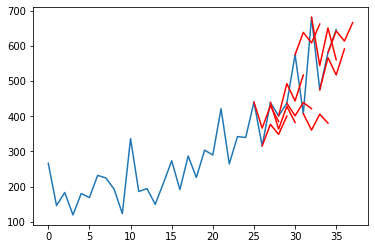

In [19]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 
# plot forecasts
plot_forecasts(series, forecasts, n_test)

In [13]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# configure
n_lag = 1
n_seq = 3
n_test = 10
n_epochs = 5
n_batch = 1
n_neurons = 1

In [5]:
# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# prepare data
scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

In [6]:
n_epochs = 5
n_batch = 128
n_neurons = 150

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

IndentationError: ignored

In [16]:
# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]
 
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

In [17]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)

In [18]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
  
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 125.009568
t+2 RMSE: 69.863870
t+3 RMSE: 100.744996


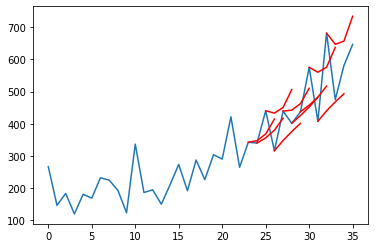

In [19]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()
 
 # plot forecasts
plot_forecasts(series, forecasts, n_test+2)